# Problem 1

For the Reuter data that we analyzed in class, we did not compare the deep learning results
with any baseline. Please compare the results with Multiclass Logistic Regression, which can
serve as a baseline. Report your findings and submit the Python code as an appendix. (You can
fit a multiclass logistic regression by modifying the code for Reuter data slightly.)


In [22]:

from keras.datasets import reuters
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

(num_words,) = (10000,)
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=num_words)

def vectorize_sequences(sequences, dimension=num_words):
    results = np.zeros((len(sequences), dimension), dtype='float32')
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.0
    return results

X_train = vectorize_sequences(train_data)
X_test  = vectorize_sequences(test_data)
y_train = train_labels
y_test  = test_labels

logreg = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1
)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
acc      = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Baseline Logistic Regression")
print(f"  Test accuracy:    {acc:.4f}")
print(f"  Macro F1-score:   {f1_macro:.4f}")
print(f"  Weighted F1-score:{f1_weighted:.4f}")


Baseline Logistic Regression
  Test accuracy:    0.7925
  Macro F1-score:   0.5666
  Weighted F1-score:0.7816


Conclusion: The deep learning model outperforms the simple multinomial logistic regression by roughly 23 percentage points in overall accuracy, demonstrating that the network’s hidden representations capture topic distinctions that the linear baseline cannot.

# Question 2

In this problem, you will analyze an SMS spam dataset collected from
https://dl.acm.org/doi/10.1145/2034691.2034742. The dataset contains both legitimate SMS
messages (labeled as “ham”) and spam messages (labeled as “spam”). I have prepared a data
matrix where the (𝑖, 𝑗)-th element represents the count of the j-th word in the i-th message. I
have included words that appear in at least 1% of the messages. Your task is to build a deep
neural network model to classify “ham” and “spam” messages. Write a short report about your
analysis. Consider the following questions: Have you compared the results with random
guessing or baselines? Is the metric “accuracy” a good choice for this analysis? The dataset
“messages.csv” is attached.

In [23]:
display(df)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V1252,V1253,V1254,V1255,V1256,V1257,V1258,V1259,V1260,V1261
0,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5571,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('Data/messages.csv')


# Prepare features and labels
X = df.drop('V1', axis=1).values
y = df['V1'].map({'ham': 0, 'spam': 1}).values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Baseline: random guessing based on training spam proportion
spam_prob = y_train.mean()
rng = np.random.RandomState(42)
y_pred_random = rng.rand(len(y_test)) < spam_prob

# Multiclass Logistic Regression baseline
lr = LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Deep Neural Network
input_dim = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[es], verbose=0)
y_prob_nn = model.predict(X_test).ravel()
y_pred_nn = y_prob_nn > 0.5

# Metric computation
def compute_metrics(y_true, y_pred, y_prob=None):
    m = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }
    if y_prob is not None:
        m['roc_auc'] = roc_auc_score(y_true, y_prob)
    return m

metrics_random = compute_metrics(y_test, y_pred_random, np.full_like(y_test, spam_prob))
metrics_lr = compute_metrics(y_test, y_pred_lr, y_prob_lr)
metrics_nn = compute_metrics(y_test, y_pred_nn, y_prob_nn)

# Compile results
metrics_df = pd.DataFrame(
    [metrics_random, metrics_lr, metrics_nn],
    index=['Random Guessing', 'Logistic Regression', 'Neural Network']
)

# Display results
display("Model Comparison Metrics", metrics_df)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


'Model Comparison Metrics'

,accuracy,precision,recall,f1_score,roc_auc
Random Guessing,0.758744,0.125000,0.134228,0.129450,0.500000
Logistic Regression,0.986547,1.000000,0.899329,0.946996,0.986779
Neural Network,0.985650,0.985401,0.906040,0.944056,0.979268


In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score
)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# 1) Load and split
df = pd.read_csv('Data/messages.csv')
X = df.drop('V1', axis=1).values
y = df['V1'].map({'ham': 0, 'spam': 1}).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 2) Keras-based logistic regression baseline
log_baseline = Sequential([
    Dense(1, activation='sigmoid', input_dim=X_train.shape[1])
])
log_baseline.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
log_baseline.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=32,
    epochs=50,
    callbacks=[es],
    verbose=0
)

y_prob_lr = log_baseline.predict(X_test).ravel()
y_pred_lr = (y_prob_lr > 0.5).astype(int)

# 3) Deep neural network
dnn = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
dnn.compile(optimizer='adam', 
            loss='binary_crossentropy', 
            metrics=['accuracy'])
dnn.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=32,
    epochs=50,
    callbacks=[es],
    verbose=0
)

y_prob_nn = dnn.predict(X_test).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# 4) Metrics & reports
print("=== Logistic Regression (Keras) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_prob_lr):.4f}")
print(classification_report(y_test, y_pred_lr, digits=4))

print("\n=== Deep Neural Network ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_prob_nn):.4f}")
print(classification_report(y_test, y_pred_nn, digits=4))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
=== Logistic Regression (Keras) ===
Accuracy: 0.9857
ROC AUC : 0.9827
              precision    recall  f1-score   support

           0     0.9837    1.0000    0.9918       966
           1     1.0000    0.8926    0.9433       149

    accuracy                         0.9857      1115
   macro avg     0.9919    0.9463    0.9675      1115
weighted avg     0.9859    0.9857    0.9853      1115


=== Deep Neural Network ===
Accuracy: 0.8664
ROC AUC : 0.9567
              precision    recall  f1-score   support

           0     0.8664    1.0000    0.9284       966
           1     0.0000    0.0000    0.0000       149

    accuracy                         0.8664      1115
   macro avg     0.4332    0.5000    0.4642      1115
weighted avg     0.7506    0.8664    0.8043      1115



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

# 1) Load data
df = pd.read_csv('Data/messages.csv')
X = df.drop('V1', axis=1).values
y = df['V1'].map({'ham': 0, 'spam': 1}).values

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 3) Scale inputs (MaxAbsScaler preserves sparsity & non-negativity)
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4) Compute class weights to address imbalance
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, cw))

# 5) Build improved DNN with BatchNorm and reduced Dropout
input_dim = X_train_scaled.shape[1]
inputs = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 6) Train with early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1
)

# 7) Evaluate on test set
y_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("=== Improved DNN Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

print(classification_report(y_test, y_pred, digits=4))


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6981 - loss: 0.5365 - precision: 0.2990 - recall: 0.8276 - val_accuracy: 0.8520 - val_loss: 0.4181 - val_precision: 1.0000 - val_recall: 0.0435
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9498 - loss: 0.1353 - precision: 0.7313 - recall: 0.9845 - val_accuracy: 0.8767 - val_loss: 0.2954 - val_precision: 1.0000 - val_recall: 0.2029
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9828 - loss: 0.0736 - precision: 0.8987 - recall: 0.9800 - val_accuracy: 0.8991 - val_loss: 0.2350 - val_precision: 1.0000 - val_recall: 0.3478
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0488 - precision: 0.9357 - recall: 0.9896 - val_accuracy: 0.9350 - val_loss: 0.1827 - val_precision: 1.0000 - val_recall: 0.5797
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0347 - precision: 0.9690 - recall: 0.9880 - val_accuracy: 0.9574 - val_loss: 0.1367 

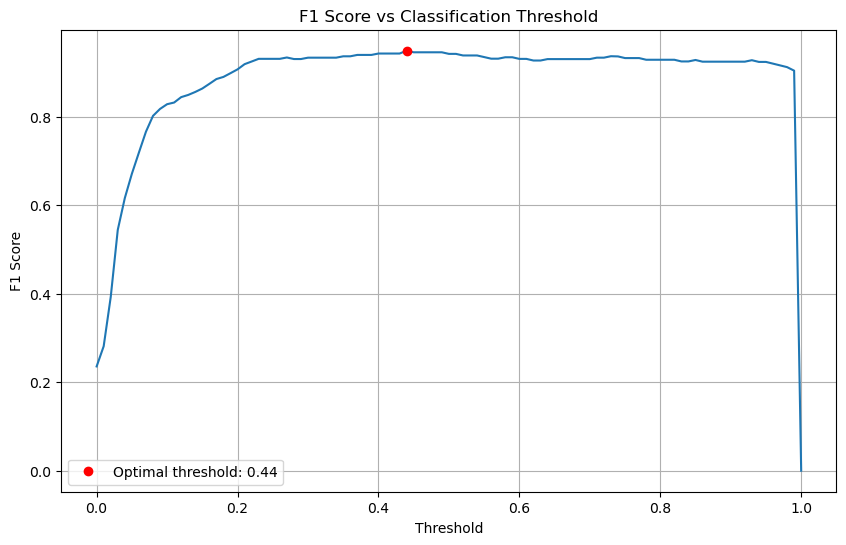

Optimal threshold: 0.440
Best F1 score: 0.949


In [20]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Generate range of thresholds
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    y_pred_thresh = (y_prob > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

# Plot F1 curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.title('F1 Score vs Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)

# Find and plot optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

plt.plot(optimal_threshold, optimal_f1, 'ro', label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.legend()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Best F1 score: {optimal_f1:.3f}")